In [ ]:
import numpy as np
from keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#EVALUATE MODEL AND GENERATE GRAPHS

from tensorflow import keras
from keras.layers import Activation
from keras.utils import get_custom_objects
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the Swish activation function
def swish(x):
    return K.sigmoid(x) * x

# Register the Swish function as a custom activation function
get_custom_objects().update({'swish': Activation(swish),'Activation': Activation})

def evaluate_models(models, test_generators):
    num_models = len(models)

    # Loop through each model and corresponding test generator
    for i in range(num_models):
        model = models[i]
        test_generator = test_generators[i]
        print("model.output_shape[-1]  ",model.output_shape[-1])

        # Generate predictions for the test set
        if model.output_shape[-1] == 1:
          # Binary classification with single neuron in last layer
          if isinstance(model.input, list):
            predictions = model.predict([test_generator[0],test_generator[1]], verbose=1)
          else:
            predictions = model.predict(test_generator, verbose=1)
          y_pred = predictions.ravel() > 0.5
        elif model.output_shape[-1] == 2:
          # Binary classification with two neurons in last layer
          predictions = model.predict(test_generator, verbose=1)
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions[:, 1] # Use probabilities for positive class
        else:
          # Multi-class classification
          if isinstance(model.input, list):
            predictions = model.predict(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)
          else:
            print('hooo')
            #test_steps_per_epoch = numpy.math.ceil(test_batches.samples / test_batches.batch_size)
            predictions = model.predict_generator(test_generator,test_generator.n // test_generator.batch_size+1, verbose=1)
          y_pred = np.argmax(predictions, axis=1)
          y_prob = predictions

        # Convert the one-hot encoded labels to integers
        y_true = test_generator.classes

        # Calculate various metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        # Print the metrics
        print(f"\n\nModel {i+1} Metrics")
        print('Accuracy: {:.4f}'.format(accuracy))
        print('Precision: {:.4f}'.format(precision))
        print('Recall: {:.4f}'.format(recall))
        print('F1-score: {:.4f}'.format(f1))


        # Get the class indices from the test generator
        class_indices = test_generator.class_indices

        # Invert the class indices to get the class labels with sequence
        class_labels = dict((v, k) for k, v in class_indices.items())

        # Map the integer labels to their corresponding class labels
        y_true_labels = [class_labels[label] for label in y_true]
        y_pred_labels = [class_labels[label] for label in y_pred]


        # Print confusion matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(class_labels.values()))
        print('Confusion matrix:\n', cm)

        # Plot confusion matrix with actual labels
        sns.set(font_scale=1.4)
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, square=True, xticklabels=class_labels.values(), yticklabels=class_labels.values())
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        #bar graph
        metrics_dict={
            'Accuracy':accuracy,
            'Precision':precision,
            'Recall':recall,
            'F1-Score':f1

        }

        plt.bar(metrics_dict.keys(),metrics_dict.values())
        plt.title('Metrics')
        plt.show()

        if model.output_shape[-1] == 1 or model.output_shape[-1] == 2:
            # Binary classification with one or two neurons in last layer
            tn, fp, fn, tp = cm.ravel()
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for i in range(len(fpr)):
                print("{} {}: {:.2f}".format(y_true_labels[i], class_labels[1], fpr[i]))

        if model.output_shape[-1] != 1 and model.output_shape[-1] != 2:
            # Calculate ROC curve and AUC for multi-class classification
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            n_classes = model.output_shape[-1]

            for j in range(n_classes):
                fpr[j], tpr[j], _ = roc_curve(y_true == j, y_prob[:, j])
                roc_auc[j] = auc(fpr[j], tpr[j])

            # Plot ROC curve
            sns.set(font_scale=1.4)
            plt.figure(figsize=(8, 8))
            for j in range(n_classes):
                plt.plot(fpr[j], tpr[j], label='ROC curve for {} (area = {:.2f})'.format(class_labels[j], roc_auc[j]), linewidth=2)
            plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()

            # Print ROC curve with class labels
            print("ROC Curve with class labels:")
            for j in range(n_classes):
                for i in range(len(fpr[j])):
                    print("{} {}: {:.2f}".format(class_labels[j], y_true_labels[i], fpr[j][i]))




In [ ]:
# EVALUATE PERFORMANCE OF VGG15TEALEAF MODEL

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})

# Load trained model
model = load_model('/content/drive/MyDrive/TeaLeafNet/vgg16TeaLeaf.h5')
#model.summary()
# Define test generator with data augmentation
test_batches = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)

predictions = model.predict(test_batches,test_batches.n // test_batches.batch_size+1, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_prob = predictions

print(y_pred)
#print(predictions[44])
#evaluate_models([model],[test_batches])


Found 87 images belonging to 8 classes.
9/9 [==============================] - 8s 755ms/step
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 5 1 1 1 1 2 2 0 2 2 0 4 1 0 2 3 3 3 3 7 1
 3 3 3 3 3 4 4 4 4 4 2 1 4 2 2 5 5 5 5 3 5 5 6 1 7 1 0 6 6 6 6 6 1 6 6 6 7
 7 7 7 7 7 7 7 1 7 7 7 7 2]


In [ ]:

train_path = '/content/drive/MyDrive/TeaDataSet/train'
valid_path = '/content/drive/MyDrive/TeaDataSet/valid'
test_path = '/content/drive/MyDrive/TeaDataSet/test'


get_custom_objects().update({'f1_m': f1_m,'precision_m':precision_m, 'recall_m':recall_m})

train_batches_vgg16 = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches_vgg16 = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches_vgg16 = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)

train_batches_googlenet = ImageDataGenerator( rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',preprocessing_function=tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches_googlenet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches_googlenet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


train_batches_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(train_path, target_size=(224,224), batch_size=10)
valid_batches_resnet = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(valid_path, target_size=(224,224), batch_size=10)
test_batches_resnet = ImageDataGenerator(rescale=1./255,preprocessing_function=tf.keras.applications.resnet50.preprocess_input).flow_from_directory(test_path, target_size=(224,224), batch_size=10,shuffle=False)


Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 706 images belonging to 8 classes.
Found 87 images belonging to 8 classes.
Found 87 images belonging to 8 classes.


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


9/9 [==============================] - 23s 2s/step
preds1  [5.8467400e-01 2.4469689e-04 3.2269323e-01 2.4565365e-04 9.1639578e-02
 5.2427931e-05 1.4995283e-04 3.0053113e-04]
preds2  [0.99999994 0.         0.         0.         0.         0.
 0.         0.        ]
preds3  [3.4102637e-01 1.7459932e-04 4.0478790e-01 1.0766266e-04 2.5315982e-01
 9.9497352e-05 5.1585160e-04 1.2830488e-04]
googlenet weighted  [4.17624284e-01 2.44696887e-04 2.58154583e-01 2.23321496e-04
 7.33116627e-02 5.24279312e-05 1.39241914e-04 2.73210119e-04]
predicted_classes [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 0 4 1 0 2 3 3 3 3 7 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 2 4 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7
 7 7 7 7 7 7 7 7 7 7 7 7 7]
true_labels :  [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7
 7 7 7 7 7 7 7 7 7 7 7 7 7]


Model Metrics
Accuracy: 0.9310
Precision: 0.9317
Recall: 0.9310
F1-score: 0.92

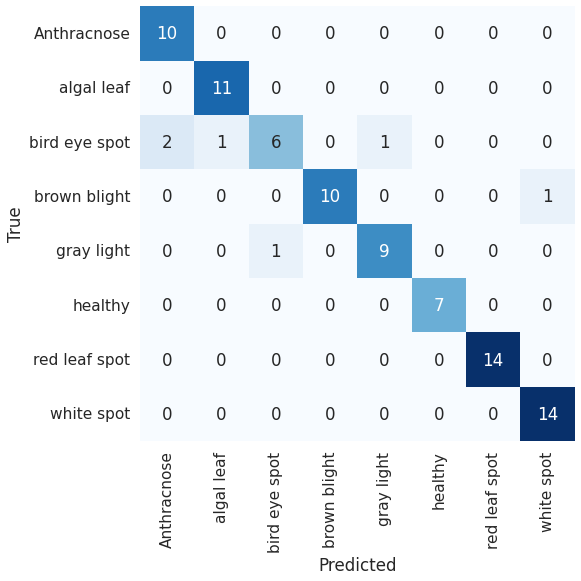

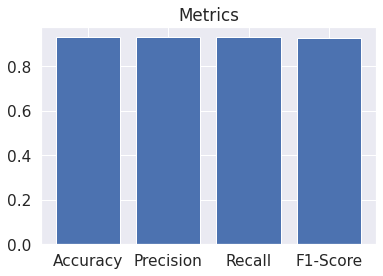

n_classes 8


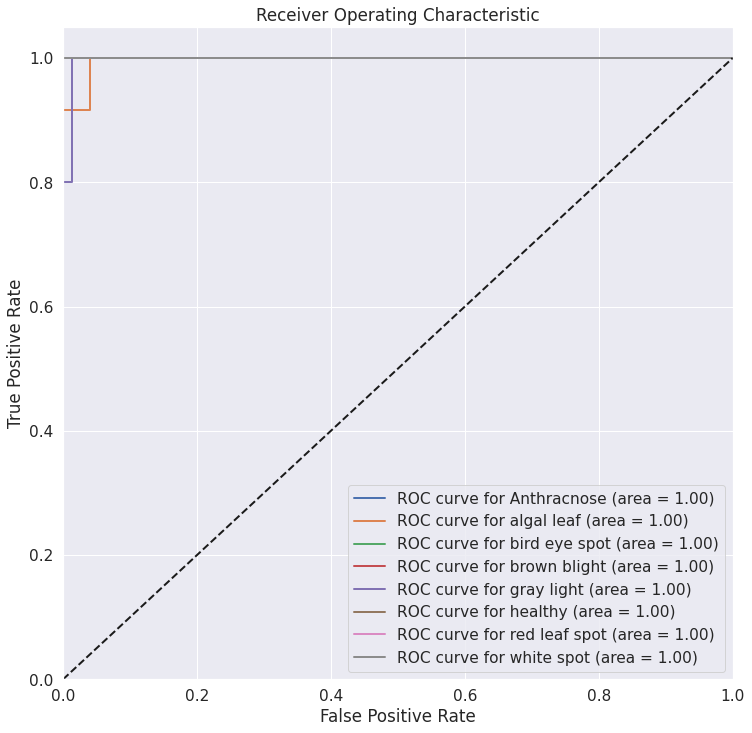

ROC Curve with class labels:
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 0.00
Anthracnose Anthracnose: 1.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.00
algal leaf Anthracnose: 0.04
algal leaf Anthracnose: 0.04
algal leaf Anthracnose: 1.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 0.00
bird eye spot Anthracnose: 1.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 0.00
brown blight Anthracnose: 1.00
gray light Anthracnose: 0.00
gray light Anthracnose: 0.00
gray light Anthracnose: 0.00
gray light Anthracnose: 0.01
gray light Anthracnose: 0.01
gray light Anthracnose: 1.00
healthy Anthracnose: 0.00
healthy Anthracnose: 0.00
healthy Anthracnose: 0.00
healthy Anthracnose: 1.00
red leaf spot Anthracnose: 0.00
red leaf spot Anthracnose: 0.00
red leaf spot Anthracnose: 0.00
red leaf spot Anthracnose: 1.00
white spot Anthracn

In [ ]:



import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.callbacks import LearningRateScheduler
from keras.metrics import categorical_crossentropy
from keras.layers import Activation
from keras.utils import get_custom_objects

import matplotlib.pyplot as plt
import os
import shutil
import random
import glob
import math
import tensorflow as tf
%matplotlib inline

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics as metrics
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Flatten, Reshape
from keras.utils import Sequence
from keras.activations import softmax
from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives +
    K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))



# Load the pre-trained models
model1 = load_model('/content/drive/MyDrive/TeaLeafNet/googlenetmodel9mar2023.h5')
model2 = load_model('/content/drive/MyDrive/TeaLeafNet/vgg16TeaLeaf.h5')
model3 = load_model('/content/drive/MyDrive/TeaLeafNet/resnet5013Mar.h5')

#model2.summary()
# Assign weights to the models
weight1 = 0.5  # Weight for GoogLeNet model
weight2 = 0.3  # Weight for ResNet50 model
weight3 = 0.2  # Weight for VGG16 model

# Load your test data and preprocess it as required by your models

# Use the models to obtain predicted probabilities for each class for each of the three models on your test set
preds1 =  np.array(model1.predict(test_batches_googlenet)[2])
preds2 = np.array(model2.predict(test_batches_vgg16))
preds3 = np.array(model3.predict(test_batches_resnet))

print("preds1 ", preds1[0])
print("preds2 ",preds2[0])
print("preds3 ",preds3[0])

vgg16_weights=[0.91304348, 0.82608696, 0.47826087, 0.91304348, 0.65217391, 0.86956522, 0.86956522, 0.92307692]
googlenet_weights=[0.71428571, 1.0, 0.8, 0.90909091, 0.8, 1.0, 0.92857143, 0.90909091]
resnet50_weights=[0.57142857, 1.0, 0.66666667, 0.83333333, 0.8, 1.0, 0.93333333, 0.92307692]



# Multiply the weights for each model with the prediction array
vgg16_weighted_prediction = np.multiply(vgg16_weights, preds2)
googlenet_weighted_prediction = np.multiply(googlenet_weights, preds1)
resnet50_weighted_prediction = np.multiply(resnet50_weights, preds3)
print("googlenet weighted ",googlenet_weighted_prediction[0])

# Combine the weighted predictions for each class from each model
final_weighted_prediction = np.mean([vgg16_weighted_prediction, googlenet_weighted_prediction, resnet50_weighted_prediction], axis=0)

# Find the class with the highest probability for each sample
predicted_classes = np.argmax(final_weighted_prediction, axis=1)

# Print the predicted classes
print("predicted_classes",predicted_classes)

true_labels=test_batches_resnet.classes
print("true_labels : ",true_labels)


accuracy = accuracy_score(true_labels, predicted_classes)
precision = precision_score(true_labels, predicted_classes, average='weighted')
recall = recall_score(true_labels, predicted_classes, average='weighted')
f1 = f1_score(true_labels, predicted_classes, average='weighted')

# Print the metrics
print(f"\n\nModel Metrics")
print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-score: {:.4f}'.format(f1))



# Get the class indices from the test generator
class_indices = test_batches_resnet.class_indices

# Invert the class indices to get the class labels with sequence
class_labels = dict((v, k) for k, v in class_indices.items())
print("class_labels : ",class_labels)

# Map the integer labels to their corresponding class labels
y_true_labels = [class_labels[label] for label in true_labels]
y_pred_labels = [class_labels[label] for label in predicted_classes]


# Print confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=list(class_labels.values()))
print('Confusion matrix:\n', cm)

# Plot confusion matrix with actual labels
sns.set(font_scale=1.4)
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, square=True, xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#bar graph
metrics_dict={
    'Accuracy':accuracy,
    'Precision':precision,
    'Recall':recall,
    'F1-Score':f1

}

plt.bar(metrics_dict.keys(),metrics_dict.values())
plt.title('Metrics')
plt.show()



fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = model1.output_shape[1][1]

print("n_classes",n_classes)

for j in range(n_classes):
    fpr[j], tpr[j], _ = roc_curve(predicted_classes == j, final_weighted_prediction[:, j])
    roc_auc[j] = auc(fpr[j], tpr[j])

# Plot ROC curve
sns.set(font_scale=1.4)
plt.figure(figsize=(12, 12))
for j in range(n_classes):
    plt.plot(fpr[j], tpr[j], label='ROC curve for {} (area = {:.2f})'.format(class_labels[j], roc_auc[j]), linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Print ROC curve with class labels
print("ROC Curve with class labels:")
for j in range(n_classes):
    for i in range(len(fpr[j])):
        print("{} {}: {:.2f}".format(class_labels[j], y_true_labels[i], fpr[j][i]))

confusion matrix for vgg 16 model
cls 1:   2: 3: 4:  5: 6:    7:
 0:[10  0  0  0  0  0  0  0]
 1:[ 1  9  0  0  0  1  0  0]
 2:[ 3  1  5  0  1  0  0  0]
 3:[ 0  1  0  9  0  0  0  1]
 4:[ 0  1  3  0  6  0  0  0]
 5:[ 0  0  0  1  0  6  0  0]
 6:[ 1  3  0  0  0  0  9  1]
 7:[ 0  1  1  0  0  0  0 12]

confusion matrix for googlenet model
       0:  1:  2:  3: 4: 5: 6: 7:
 [0:[ 5  0  4  0  1  0  0  0]
  1:[ 0 11  0  0  0  0  0  0]
  2:[ 0  0  8  0  2  0  0  0]
  3:[ 0  1  0 10  0  0  0  0]
  4:[ 0  0  2  0  8  0  0  0]
  5:[ 0  0  0  0  0  7  0  0]
  6:[ 0  0  0  0  0  0 13  1]
 7:[ 0  0  0  4  0  0  0 10]]

confusion matrix for resnet50
       0: 1: 2: 3: 4: 5: 6: 7:
[0:[ 4  0  2  0  4  0  0  0]
  1:[ 0 11  0  0  0  0  0  0]
  2:[ 1  0  4  0  5  0  0  0]
  3:[ 0  0  0 10  0  0  0  1]
  4:[ 1  0  1  0  8  0  0  0]
  5:[ 0  0  0  0  0  6  1  0]
  6:[ 0  0  0  0  0  0 14  0]
  7:[ 0  0  0  1  0  0  1 12]] **bold text**